In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csr_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
import itertools
from sklearn.metrics import silhouette_samples, silhouette_score

import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, fpmax, fpgrowth

In [2]:
%matplotlib inline

In [3]:
def read_dataset(fname):
    # 指定索引
    data = pd.read_csv(fname, index_col=0) 
    data = data.reset_index()
    # 取喜好類型
    data = data[['weight','Gender','ethnic_food','greek_food','indian_food','italian_food','persian_food','thai_food']]
    # 處理遺缺值
    data = data.dropna()
    # 指定索引
    data = data.reset_index(drop=True)
    return data

biased_dataset = read_dataset('food_coded.csv')

biased_dataset['weight']=biased_dataset['weight'].astype(int)


def BMIStandard(biased_dataset):
    if biased_dataset["weight"]<135:
        biased_dataset["weight_range"] = "first"
    elif biased_dataset["weight"]<155:
        biased_dataset["weight_range"]= "second"
    elif biased_dataset["weight"]<180:
        biased_dataset["weight_range"] = "third"
    else:
        biased_dataset["weight_range"] = "forth"
    return biased_dataset
biased_dataset=biased_dataset.apply(BMIStandard,axis=1)
biased_dataset

labels = biased_dataset["weight_range"].unique().tolist()
biased_dataset["weight_range"]=biased_dataset["weight_range"].apply(lambda n: labels.index(n))

In [4]:
#描述性統計- data describe
def describe(df):
    df_des=df.describe(include='all',datetime_is_numeric=True)
    return df_des.round(2)
data_des = describe(biased_dataset)
data_des

,weight,Gender,ethnic_food,greek_food,indian_food,italian_food,persian_food,thai_food,weight_range
count,121.00,121.00,121.00,121.00,121.00,121.00,121.00,121.00,121.00
mean,159.12,1.38,3.74,3.46,3.12,4.74,2.77,3.31,1.41
std,32.50,0.49,1.18,1.37,1.49,0.57,1.41,1.44,1.12
min,100.00,1.00,1.00,1.00,1.00,3.00,1.00,1.00,0.00
25%,135.00,1.00,3.00,3.00,2.00,5.00,2.00,2.00,0.00
50%,155.00,1.00,4.00,4.00,3.00,5.00,3.00,3.00,1.00
75%,180.00,2.00,5.00,5.00,5.00,5.00,4.00,5.00,2.00
max,265.00,2.00,5.00,5.00,5.00,5.00,5.00,5.00,3.00


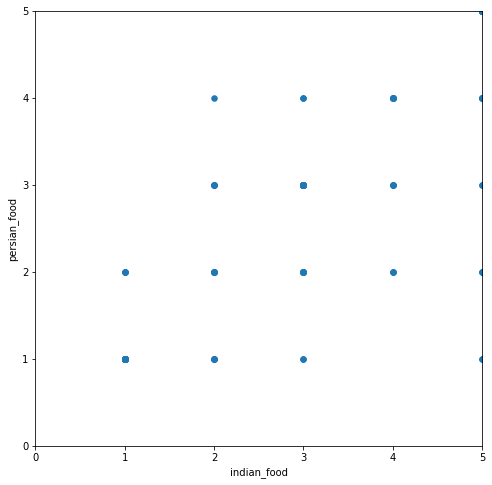

In [5]:
#將上述106筆資料進行視覺化分析，圖表呈現
def draw_scatterplot(x_data, x_label, y_data, y_label):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.scatter(x_data, y_data, s=30)
# Plot the scatterplot
draw_scatterplot(biased_dataset['indian_food'],'indian_food', biased_dataset['persian_food'], 'persian_food')

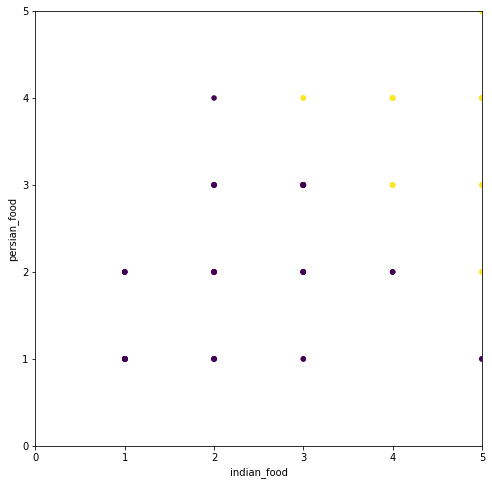

In [6]:
#進行分群：將所有用戶通過應用K-Means將樣本分解為兩個不同的組
# 若分兩群，如下圖
from sklearn.cluster import KMeans

#抓取訓練資料集
X = biased_dataset[['indian_food','persian_food']].values

#K值為2
kmeans_1 = KMeans(n_clusters=2)
predictions = kmeans_1.fit_predict(X)

#畫圖
def draw_clusters(biased_dataset, predictions, cmap='viridis'):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel('indian_food')
    ax.set_ylabel('persian_food')
    
    clustered = pd.concat([biased_dataset.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
    plt.scatter(clustered['indian_food'], clustered['persian_food'], c=clustered['group'], s=20, cmap=cmap)
    
# Plot
draw_clusters(biased_dataset, predictions)

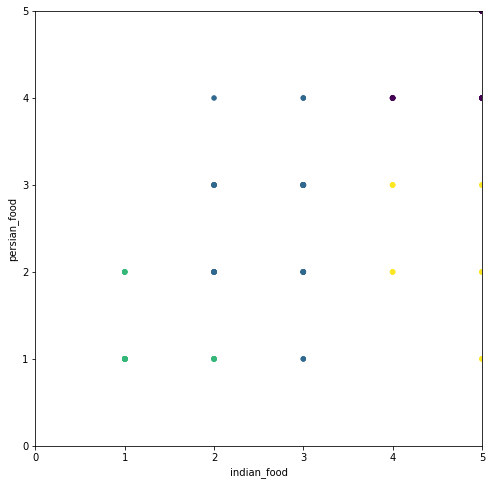

In [7]:
#K值為4
# 若分四群，如下圖，分越多每一群的用戶喜好越相似
kmeans_3 = KMeans(n_clusters=4)
predictions_3 = kmeans_3.fit_predict(X)
draw_clusters(biased_dataset, predictions_3)

C:\Users\user\anaconda3\envs\test1AI\lib\site-packages\ipykernel_launcher.py:9: ConvergenceWarning: Number of distinct clusters (18) found smaller than n_clusters (22). Possibly due to duplicate points in X.
  if __name__ == '__main__':
C:\Users\user\anaconda3\envs\test1AI\lib\site-packages\ipykernel_launcher.py:9: ConvergenceWarning: Number of distinct clusters (18) found smaller than n_clusters (27). Possibly due to duplicate points in X.
  if __name__ == '__main__':
C:\Users\user\anaconda3\envs\test1AI\lib\site-packages\ipykernel_launcher.py:9: ConvergenceWarning: Number of distinct clusters (18) found smaller than n_clusters (32). Possibly due to duplicate points in X.
  if __name__ == '__main__':
C:\Users\user\anaconda3\envs\test1AI\lib\site-packages\ipykernel_launcher.py:9: ConvergenceWarning: Number of distinct clusters (18) found smaller than n_clusters (37). Possibly due to duplicate points in X.
  if __name__ == '__main__':
C:\Users\user\anaconda3\envs\test1AI\lib\site-packag

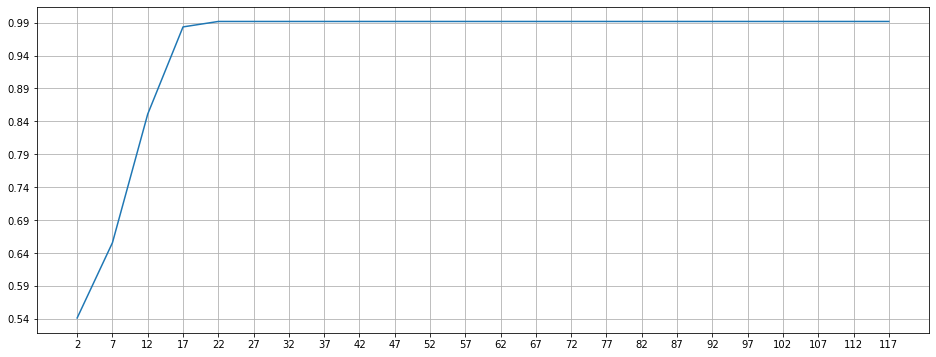

In [8]:
df = biased_dataset[['indian_food','persian_food']] # 資料

possible_k_values = range(2, len(X)+1, 5)   # 定義k值取的範圍
# possible_k_values = range(2, len(X), 3)   # 定義k值取的範圍

# 定義計算函式
# 使用kmeans ; silhouette_score
def clustering_errors(k, data):
    kmeans = KMeans(n_clusters=k).fit(data)
    predictions = kmeans.predict(data)
    silhouette_avg = silhouette_score(data, predictions)
    return silhouette_avg
#計算，透過輪廓係數比較各K值選擇，哪個比較好。
errors_per_k = [clustering_errors(k, X) for k in possible_k_values]
# Plot the each value of K vs. the silhouette score at that value
fig, ax = plt.subplots(figsize=(16, 6))
plt.plot(possible_k_values, errors_per_k)
# Ticks and grid
xticks = np.arange(min(possible_k_values), max(possible_k_values)+1, 5.0)
ax.set_xticks(xticks, minor=False)
ax.set_xticks(xticks, minor=True)
ax.xaxis.grid(True, which='both')
yticks = np.arange(round(min(errors_per_k), 2), max(errors_per_k), .05)
ax.set_yticks(yticks, minor=False)
ax.set_yticks(yticks, minor=True)
ax.yaxis.grid(True, which='both') 

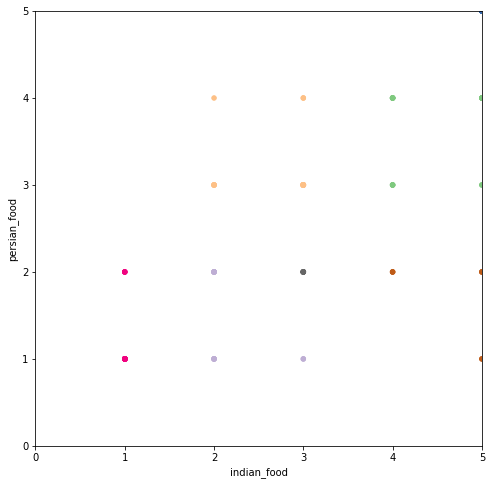

In [9]:
# 為了達到成效佳的分群，以及容易可視化。k值可解釋性，最後K值選擇7
kmeans_4 = KMeans(n_clusters=7)
predictions_4 = kmeans_4.fit_predict(X)
draw_clusters(biased_dataset, predictions_4, cmap='Accent')

In [10]:
data = biased_dataset[["indian_food","persian_food"]]

In [11]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [12]:
data

,indian_food,persian_food
0,5.0,5.0
1,4.0,4.0
2,5.0,5.0
3,2.0,2.0
4,5.0,5.0
5,5.0,5.0
6,1.0,1.0
7,5.0,5.0
8,4.0,4.0
9,1.0,2.0


In [16]:
data.head(10)

,indian_food,persian_food
0,5.0,5.0
1,4.0,4.0
2,5.0,5.0
3,2.0,2.0
4,5.0,5.0
5,5.0,5.0
6,1.0,1.0
7,5.0,5.0
8,4.0,4.0
9,1.0,2.0
